In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
from IPython.display import display
from collections import namedtuple, deque
import itertools
import matplotlib.pyplot as plt

import subprocess
import os.path
import tempfile
import random
import base64
import pprint
import json
import sys
import gym
import io

from gym import wrappers
from subprocess import check_output
from IPython.display import HTML

plt.style.use('fivethirtyeight')
np.set_printoptions(suppress=True)

%matplotlib inline

In [2]:
def make_monitored_env(env_name, monitor_mode, seed):
    mdir = tempfile.mkdtemp()
    env = gym.make(env_name)
    env = wrappers.Monitor(env, mdir, force=True, mode=monitor_mode)
    env.seed(seed)
    return env

In [3]:
def plot_rewards(rewards):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(np.arange(len(rewards)), rewards)
    plt.ylabel('Rewards')
    plt.xlabel('Episode')
    plt.show()

In [4]:
def get_videos_html(env_videos, title, max_n_videos=3):
    videos = np.array(env_videos)
    n_videos = min(max_n_videos, len(videos))
    idxs = np.linspace(0, len(videos) - 1, n_videos).astype(int)
    videos = videos[idxs,:]

    strm = '<h2>{}<h2>'.format(title)
    for video_path, meta_path in videos:
        video = io.open(video_path, 'r+b').read()
        encoded = base64.b64encode(video)

        with open(meta_path) as data_file:    
            meta = json.load(data_file)

        html_tag = """
        <h3>{0}<h3/>
        <video width="960" height="540" controls>
            <source src="data:video/mp4;base64,{1}" type="video/mp4" />
        </video>"""
        strm += html_tag.format('Episode ' + str(meta['episode_id']), encoded.decode('ascii'))
    return strm

In [5]:
def get_gif_html(env_videos, title, max_n_videos=3):
    videos = np.array(env_videos)
    n_videos = min(max_n_videos, len(videos))
    idxs = np.linspace(0, len(videos) - 1, n_videos).astype(int)
    videos = videos[idxs,:]

    strm = '<h2>{}<h2>'.format(title)
    for video_path, meta_path in videos:
        basename = os.path.splitext(video_path)[0]
        gif_path = basename + '.gif'
        if not os.path.exists(gif_path):
            ps = subprocess.Popen(
                ('ffmpeg', 
                 '-i', video_path, 
                 '-r', '10', 
                 '-f', 'image2pipe', 
                 '-vcodec', 'ppm', 
                 '-'), 
                stdout=subprocess.PIPE)
            output = subprocess.check_output(
                ('convert', 
                 '-delay', '5', 
                 '-loop', '0', 
                 '-', gif_path), 
                stdin=ps.stdout)
            ps.wait()

        gif = io.open(gif_path, 'r+b').read()
        encoded = base64.b64encode(gif)
            
        with open(meta_path) as data_file:    
            meta = json.load(data_file)

        html_tag = """
        <h3>{0}<h3/>
        <img src="data:image/gif;base64,{1}" />"""
        strm += html_tag.format('Episode ' + str(meta['episode_id']), encoded.decode('ascii'))
    return strm

In [6]:
class FCQ(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dims=(32,32), activation_fc=F.relu, seed=123):
        super(FCQ, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.activation_fc = activation_fc

        self.input_layer = nn.Linear(input_dim, hidden_dims[0])
        self.hidden_layers = nn.ModuleList()
        for i in range(len(hidden_dims)-1):
            self.hidden_layers.append(nn.Linear(hidden_dims[i], hidden_dims[i+1]))
        self.output_layer = nn.Linear(hidden_dims[-1], output_dim)

        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.to(self.device)

    def forward(self, state):
        x = state
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, device=self.device, dtype=torch.float32).unsqueeze(0)
        x = self.activation_fc(self.input_layer(x))
        for hidden_layer in self.hidden_layers:
            x = self.activation_fc(hidden_layer(x))
        x = self.output_layer(x)
        return x
    
    def load_experiences(self, experiences):
        states, actions, new_states, rewards, is_terminals = experiences
        states = torch.from_numpy(states).float().to(self.device)
        actions = torch.from_numpy(actions).long().to(self.device)
        new_states = torch.from_numpy(new_states).float().to(self.device)
        rewards = torch.from_numpy(rewards).float().to(self.device)
        is_terminals = torch.from_numpy(is_terminals).float().to(self.device)
        return states, actions, new_states, rewards, is_terminals

In [7]:
class FCDuelingQ(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dims=(32,32), activation_fc=F.relu, seed=123):
        super(FCDuelingQ, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.activation_fc = activation_fc

        self.input_layer = nn.Linear(input_dim, hidden_dims[0])
        self.hidden_layers = nn.ModuleList()
        for i in range(len(hidden_dims)-1):
            self.hidden_layers.append(nn.Linear(hidden_dims[i], hidden_dims[i+1]))
        self.output_value = nn.Linear(hidden_dims[-1], 1)
        self.output_layer = nn.Linear(hidden_dims[-1], output_dim)

        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.to(self.device)

    def forward(self, state):
        x = state
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, device=self.device, dtype=torch.float32).unsqueeze(0)      
        x = self.activation_fc(self.input_layer(x))
        for hidden_layer in self.hidden_layers:
            x = self.activation_fc(hidden_layer(x))
        v = self.output_value(x)
        a = self.output_layer(x)
        q = v.expand_as(a) + (a - a.mean(1, keepdim=True).expand_as(a))
        return q
    
    def load_experiences(self, experiences):
        states, actions, new_states, rewards, is_terminals = experiences
        states = torch.from_numpy(states).float().to(self.device)
        actions = torch.from_numpy(actions).long().to(self.device)
        new_states = torch.from_numpy(new_states).float().to(self.device)
        rewards = torch.from_numpy(rewards).float().to(self.device)
        is_terminals = torch.from_numpy(is_terminals).float().to(self.device)
        return states, actions, new_states, rewards, is_terminals

In [8]:
class ReplayBuffer():
    def __init__(self, max_samples=100000, batch_size=64):
        self.memory = deque(maxlen=max_samples)
        self.batch_size = batch_size
    def store(self, sample):
        self.memory.append(sample)
    def sample(self, batch_size=None):
        batch_size = self.batch_size if batch_size == None else batch_size
        idxs = np.random.choice(len(self.memory), batch_size)
        samples = np.array([self.memory[idx] for idx in idxs])
        batches = [np.vstack(batch_type) for batch_type in samples.T]
        return batches
    def __len__(self):
        return len(self.memory)

In [9]:
class GreedyStrategy():
    def __init__(self):
        pass
    def select_action(self, q_network, state):
        q_network.eval()

        with torch.no_grad():
            q_values = q_network(state).cpu().detach().data.numpy()
            return np.argmax(q_values)

In [10]:
class EGreedyLinearStrategy():
    def __init__(self, init_epsilon=1.0, decay_rate=0.995, min_epsilon=0.01):
        self.epsilon = init_epsilon
        self.init_epsilon = init_epsilon
        self.decay_rate = decay_rate
        self.min_epsilon = min_epsilon

    def select_action(self, q_network, state):
        q_network.eval()

        nA = q_network.output_layer.out_features
        action = np.random.randint(nA)
        if np.random.rand() > self.epsilon:
            with torch.no_grad():
                q_values = q_network(state).cpu().detach().data.numpy()
                action = np.argmax(q_values)
        self.epsilon = max(self.min_epsilon, self.decay_rate*self.epsilon)
        return action

In [11]:
class EGreedyDecayStrategy():
    def __init__(self, init_epsilon=1.0, decay_rate=1e-4, min_epsilon=0.1):
        self.t = 0
        self.init_epsilon = init_epsilon
        self.decay_rate = decay_rate
        self.min_epsilon = min_epsilon

    def select_action(self, q_network, state):
        q_network.eval()
        
        nA = q_network.output_layer.out_features
        epsilon = max(self.init_epsilon * np.exp(-self.decay_rate * self.t), 
                      self.min_epsilon)
        action = np.random.randint(nA)
        if np.random.rand() > epsilon:
            with torch.no_grad():
                q_values = q_network(state).cpu().detach().data.numpy()
                action = np.argmax(q_values)
        self.t += 1
        return action

In [12]:
class SoftMaxStrategy():
    def __init__(self, init_temp=1.0, exploration_ratio=0.9, min_temp=0.5, max_episodes=1000):
        self.t = 0
        self.init_temp = init_temp
        self.exploration_ratio = exploration_ratio
        self.min_temp = min_temp
        self.max_episodes = max_episodes

    def select_action(self, q_network, state):
        q_network.eval()
        nA = q_network.output_layer.out_features
        nS = q_network.input_layer.in_features

        temp = 1 - self.t / (self.max_episodes * self.exploration_ratio)
        temp = (self.init_temp - self.min_temp) * temp + self.min_temp
        temp = np.clip(temp, self.min_temp, self.init_temp)
        temp = np.round(max(temp, 0.01), 2)
        
        with torch.no_grad():
            q = q_network(state).cpu().detach().numpy()
            a = q - q.mean()
            a_scaled = a/temp
            exp_a = np.exp(a/temp)
            probs = exp_a / np.sum(exp_a)
            isnan = np.isnan(probs)
            probs[isnan] = 1.0/sum(isnan)
            assert np.isclose(probs.sum(), 1.0)
            action = np.random.choice(np.arange(nA), size=1, p=probs)[0]
            return action

In [13]:
class DQNAgent():
    def __init__(self, replay_buffer, q_network, q_target, optimizer, 
                 behavioral_strategy, update_every_timesteps=10, polyak_avg_update=True, double_learning=True,
                 gamma=1.0, tau=0.1, debug_print_every_episodes=25, save_model_every_episodes=500):
        self.replay_buffer = replay_buffer
        self.q_network = q_network
        self.q_target = q_target
        self.optimizer = optimizer
        self.behavioral_strategy = behavioral_strategy
        self.update_every_timesteps = update_every_timesteps
        self.polyak_avg_update = polyak_avg_update
        self.double_learning = double_learning
        self.gamma = gamma
        self.tau = tau
        self.debug_print_every_episodes = debug_print_every_episodes
        self.save_model_every_episodes = save_model_every_episodes


    def optimize_model(self, experiences):
        self.q_network.train()
        states, actions, rewards, next_states, is_terminals = experiences
        batch_size = len(is_terminals)

        if self.double_learning:
            argmax_a_q_sp = self.q_network(next_states).detach().max(1)[1]
        else:
            argmax_a_q_sp = self.q_target(next_states).detach().max(1)[1]

        max_a_q_sp = self.q_target(next_states).detach()
        max_a_q_sp = max_a_q_sp[np.arange(batch_size), argmax_a_q_sp].unsqueeze(1)
        target_q_s = rewards + (self.gamma * max_a_q_sp * (1 - is_terminals))

        q_sa = self.q_network(states).gather(1, actions)
        
        loss = F.mse_loss(q_sa, target_q_s)
        self.optimizer.zero_grad()
        loss.backward()
        for param in self.q_network.parameters():
            param.grad.data.clamp_(-10, 10)
        self.optimizer.step()


    def train(self, env, max_episodes, max_mean_reward):
        nS = env.observation_space.shape[0]
        nA = env.action_space.n
        total_timestep = 0
        episode_reward = []
        self.q_target.eval()
        
        for episode in range(max_episodes+1):

            state, is_terminal = env.reset(), False
            episode_reward.append(0)

            for timestep in itertools.count():
                total_timestep += 1
                
                action = self.behavioral_strategy.select_action(self.q_network, state)
                new_state, reward, is_terminal, _ = env.step(action)
                episode_reward[-1] += reward

                experience = (state, action, reward, new_state, float(is_terminal))
                self.replay_buffer.store(experience)

                state = new_state
                
                if len(self.replay_buffer) > self.replay_buffer.batch_size * 10:
                    experiences = self.replay_buffer.sample()
                    experiences = self.q_network.load_experiences(experiences)
                    self.optimize_model(experiences)
                
                if total_timestep % self.update_every_timesteps == 0:
                    if self.polyak_avg_update:
                        for target_param, local_param in zip(self.q_target.parameters(), self.q_network.parameters()):
                            target_param.data.copy_(self.tau*local_param.data + (1.0-self.tau)*target_param.data)
                    else:
                        self.q_target.load_state_dict(self.q_network.state_dict())

                if is_terminal:
                    break

            mean_reward = np.mean(episode_reward[-100:])
            if episode % self.debug_print_every_episodes == 0:
                print('ep {:04}, step {:06}, last ep rew {:03}, last 100 ep mean rew {:.2f}'.format(
                    episode, total_timestep, int(episode_reward[-1]), mean_reward))
            if episode % self.save_model_every_episodes == 0:
                torch.save(agent.q_network.state_dict(), 'checkpoints/checkpoint_{}.pth'.format(episode))
            if mean_reward >= max_mean_reward:
                print('ep {:04}, step {:06}, last ep rew {:03}, last 100 ep mean rew {:.2f}'.format(
                    episode, total_timestep, int(episode_reward[-1]), mean_reward))
                torch.save(agent.q_network.state_dict(), 'checkpoints/checkpoint_{}.pth'.format(episode))
                break

        env.close()
        return episode_reward

    
    def evaluate(self, env, behavioral_strategy, episodes=10, render=True):
        rewards = []
        for episode in range(episodes):
            state, is_terminal = env.reset(), False
            rewards.append(0)
            for t in itertools.count():
                if render: env.render()
                action = behavioral_strategy.select_action(self.q_network, state)
                state, reward, is_terminal, _ = env.step(action)
                rewards[-1] += reward
                if is_terminal:
                    break

        env.close()
        return rewards

In [14]:
env = make_monitored_env('CartPole-v0', 'training', 1234)
nS, nA = env.observation_space.shape[0], env.action_space.n

replay_buffer = ReplayBuffer(max_samples=1000000, batch_size=64)
q_network = FCDuelingQ(nS, nA, hidden_dims=(64,64))
q_target = FCDuelingQ(nS, nA, hidden_dims=(64,64))
optimizer = optim.RMSprop(q_network.parameters(), lr=0.0005)
training_strategy = EGreedyLinearStrategy()

agent = DQNAgent(replay_buffer, 
                 q_network, 
                 q_target, 
                 optimizer, 
                 training_strategy)

rewards = agent.train(env, max_episodes=2000, max_mean_reward=199)

ep 0000, step 000019, last ep rew 019, last 100 ep mean rew 19.00
ep 0025, step 000338, last ep rew 011, last 100 ep mean rew 13.00
ep 0050, step 000579, last ep rew 009, last 100 ep mean rew 11.35
ep 0075, step 000822, last ep rew 011, last 100 ep mean rew 10.82
ep 0100, step 001267, last ep rew 120, last 100 ep mean rew 12.48
ep 0125, step 002980, last ep rew 058, last 100 ep mean rew 26.42
ep 0150, step 005362, last ep rew 131, last 100 ep mean rew 47.83
ep 0175, step 010045, last ep rew 200, last 100 ep mean rew 92.23
ep 0200, step 014941, last ep rew 186, last 100 ep mean rew 136.74
ep 0225, step 019841, last ep rew 200, last 100 ep mean rew 168.61
ep 0250, step 024836, last ep rew 200, last 100 ep mean rew 194.74
ep 0275, step 029836, last ep rew 200, last 100 ep mean rew 197.91
ep 0300, step 034836, last ep rew 200, last 100 ep mean rew 198.95
ep 0312, step 037236, last ep rew 200, last 100 ep mean rew 199.20


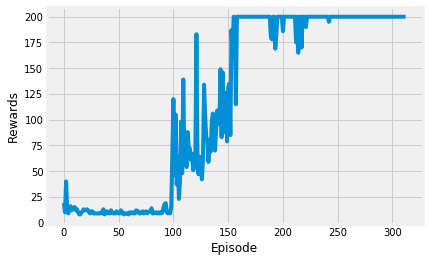

In [15]:
plot_rewards(rewards)


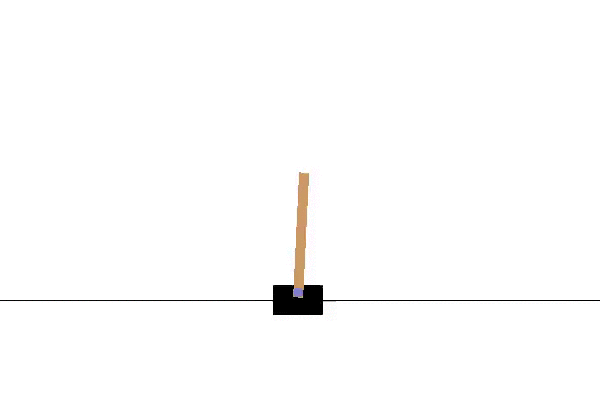
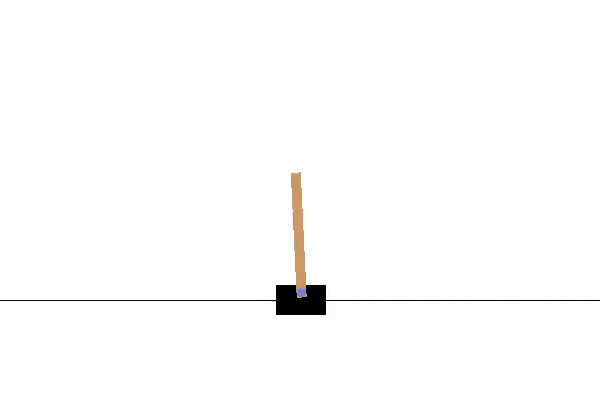
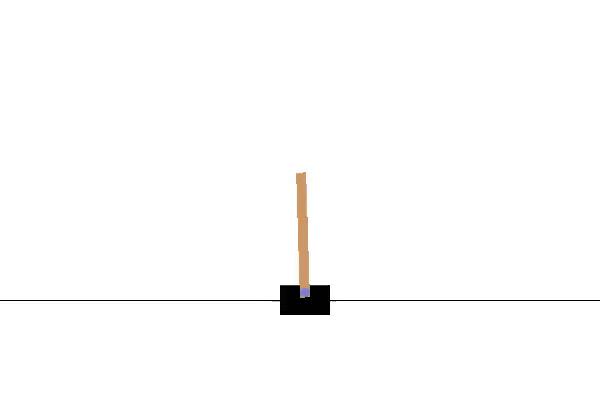
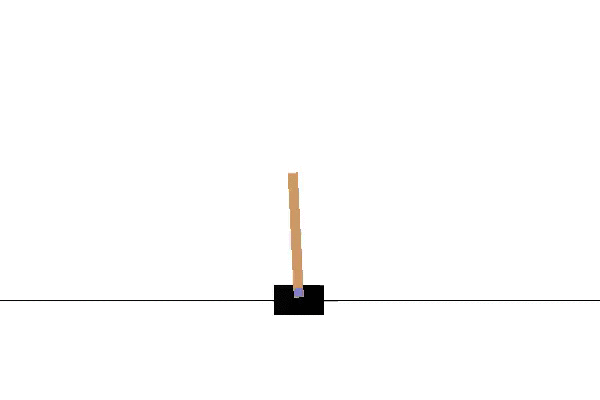
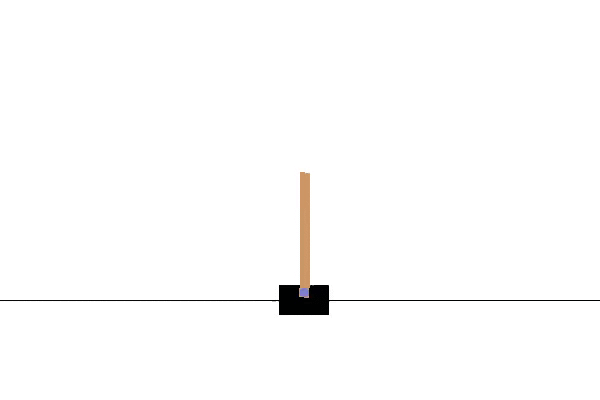

In [16]:
HTML(data=get_gif_html(env_videos=env.videos, title='Training evolution', max_n_videos=5))

In [17]:
env = make_monitored_env('CartPole-v0', 'evaluation', 1234)
evaluation_strategy = GreedyStrategy()
rewards = agent.evaluate(env, evaluation_strategy, episodes=10, render=False)

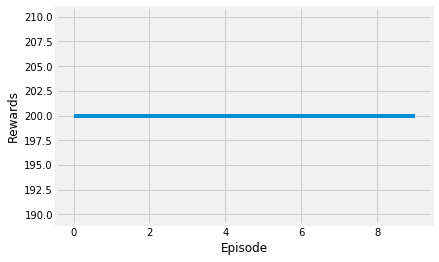

In [18]:
plot_rewards(rewards)


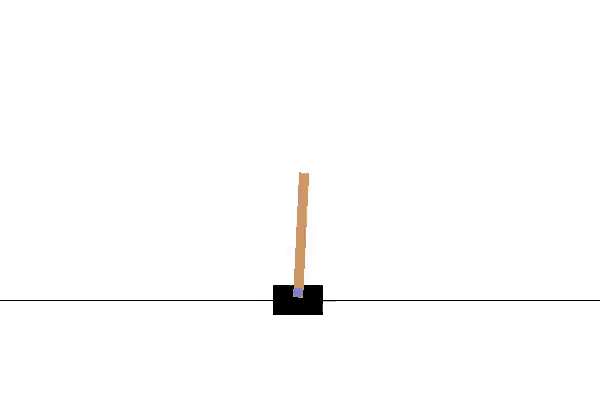
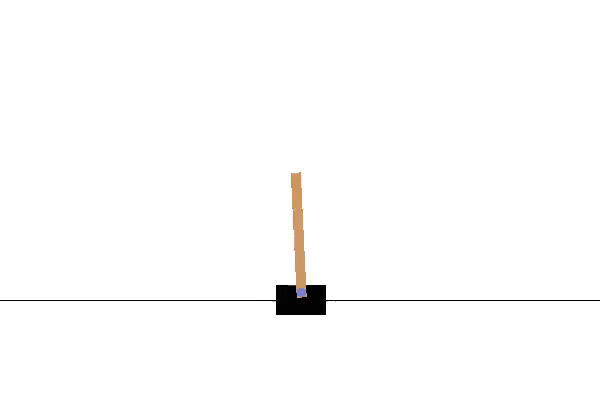
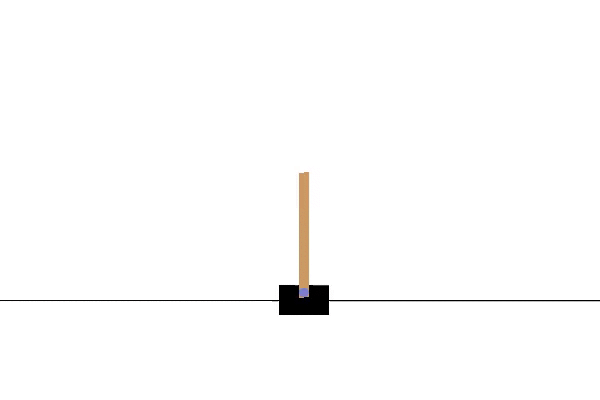

In [19]:
HTML(data=get_gif_html(env_videos=env.videos, title='Evaluation results', max_n_videos=3))